In [ ]:
from google.colab import files
files.upload()

Saving train_sample.csv to train_sample.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_dfC = pd.read_csv("train_sample.csv")
train_dfC.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


In [ ]:
train_dfC.info()
print("Valores nulos: ", train_dfC.isnull().values.any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000000 entries, 0 to 6999999
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Semana             int64  
 1   Agencia_ID         int64  
 2   Canal_ID           int64  
 3   Ruta_SAK           int64  
 4   Cliente_ID         int64  
 5   Producto_ID        int64  
 6   Venta_uni_hoy      int64  
 7   Venta_hoy          float64
 8   Dev_uni_proxima    int64  
 9   Dev_proxima        float64
 10  Demanda_uni_equil  int64  
dtypes: float64(2), int64(9)
memory usage: 587.5 MB
Valores nulos:  False


In [ ]:
train_df = train_dfC.copy()
del train_df["Agencia_ID"]
del train_df["Canal_ID"]
del train_df["Producto_ID"]
del train_df["Cliente_ID"]
del train_df["Ruta_SAK"]
del train_df["Semana"]

In [ ]:
train_df.describe()

,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
count,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06
mean,6.830656e+00,7.052256e+01,1.017120e-01,1.176823e+00,6.756646e+00
std,1.810903e+01,3.010611e+02,3.093342e+00,2.836533e+01,1.797118e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,1.886000e+01,0.000000e+00,0.000000e+00,2.000000e+00
50%,4.000000e+00,3.352000e+01,0.000000e+00,0.000000e+00,3.000000e+00
75%,7.000000e+00,6.250000e+01,0.000000e+00,0.000000e+00,7.000000e+00
max,3.556000e+03,4.024800e+04,3.360000e+03,4.950000e+04,3.556000e+03


In [ ]:
train_df.corr(method="pearson")

,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
Venta_uni_hoy,1.000000,0.824258,0.053792,0.098463,0.998238
Venta_hoy,0.824258,1.000000,0.055238,0.114565,0.821008
Dev_uni_proxima,0.053792,0.055238,1.000000,0.476197,0.030880
Dev_proxima,0.098463,0.114565,0.476197,1.000000,0.062918
Demanda_uni_equil,0.998238,0.821008,0.030880,0.062918,1.000000


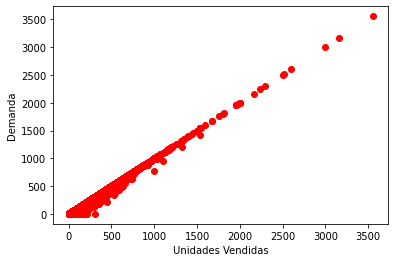

In [ ]:
plt.plot(train_df["Venta_uni_hoy"], train_df["Demanda_uni_equil"], "ro")
plt.ylabel("Demanda")
plt.xlabel("Unidades Vendidas")
plt.show()

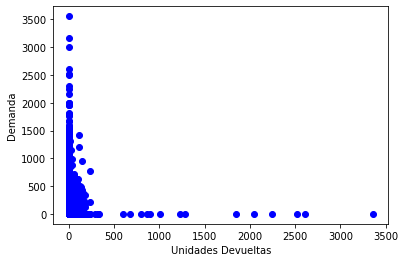

In [ ]:
plt.plot(train_df["Dev_uni_proxima"], train_df["Demanda_uni_equil"], "bo")
plt.ylabel("Demanda")
plt.xlabel("Unidades Devueltas")
plt.show()

In [ ]:
ventas = train_df["Venta_uni_hoy"]
devueltas = train_df["Dev_uni_proxima"]
demanda = train_df["Demanda_uni_equil"]

ven_menos_dev = []
for i in range(len(ventas)):
  if (ventas[i] - devueltas[i] >= 0):
    ven_menos_dev.append(ventas[i] - devueltas[i])
  else:
    ven_menos_dev.append(0)

demanda_df = pd.DataFrame({'Unidades_vend': ventas, 'Unidades_dev': devueltas, 'Ven_menos_dev': ven_menos_dev, 'Demanda': demanda})

In [ ]:
demanda_df.corr(method="pearson")

,Unidades_vend,Unidades_dev,Ven_menos_dev,Demanda
Unidades_vend,1.000000,0.049880,0.998485,0.998485
Unidades_dev,0.049880,1.000000,0.030246,0.030246
Ven_menos_dev,0.998485,0.030246,1.000000,1.000000
Demanda,0.998485,0.030246,1.000000,1.000000


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

k = 4  # número de atributos a seleccionar
entrenar = train_dfC.drop(['Demanda_uni_equil'], axis=1)
columnas = list(entrenar.columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(entrenar, train_dfC["Demanda_uni_equil"])
atrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(atrib.nonzero()[0])]
atributos

['Producto_ID', 'Venta_uni_hoy', 'Venta_hoy', 'Dev_proxima']

In [ ]:
def get_product_agg(cols):
    df_train = pd.read_csv('train_sample.csv', usecols = ['Semana', 'Producto_ID'] + cols,
                           dtype  = {'Semana': 'string',
                                     'Producto_ID':'string',
                                     'Venta_hoy':'float32',
                                     'Venta_uni_hoy': 'int32',
                                     'Dev_uni_proxima':'int32',
                                     'Dev_proxima':'float32',
                                     'Demanda_uni_equil':'int32'})
    agg  = df_train.groupby(['Producto_ID', 'Semana'], as_index=False).agg(['sum', 'max','mean'])
    agg.columns  =  ['_'.join(col).strip() for col in agg.columns.values]
    del(df_train)
    return agg

agg = get_product_agg(['Venta_uni_hoy','Dev_uni_proxima', 'Demanda_uni_equil'])

In [ ]:
agg.head(14)

Venta_uni_hoy_sum  ...  Demanda_uni_equil_mean
Producto_ID Semana                     ...                        
100         7                      25  ...                0.000000
            9                      25  ...                0.000000
1039        3                     458  ...                4.701031
            4                     543  ...                5.715789
            5                     441  ...                5.068966
            6                     411  ...                4.595506
            7                     506  ...                5.020202
            8                     501  ...                4.679245
            9                     568  ...                5.154545
1064        3                   46736  ...                2.463684
            4                   45277  ...                2.517187
            5                   37217  ...                2.262512
            6                   39100  ...                2.275636
            7                   35217  ...                2.185408

[14 rows x 9 columns]